# Sure Tomorrow (Machine Learning Linear Algebra)

The Sure Tomorrow insurance company provides a file for use of a project (file /datasets/insurance_us.csv).  Once data is loaded it will be checked for issues (there is no missing data, extreme values, and so on).  Listed below are tasks to be solved using Machine Learning. 

Features: insured person's gender, age, salary, and number of family members.
Target: number of insurance benefits received by an insured person over the last five years.


# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd
import math

#import named regression models 
from sklearn.linear_model import LinearRegression

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import f1_score


from IPython.display import display

from sklearn.preprocessing import StandardScaler




## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
3689,1,37.0,52000.0,1,0
79,1,29.0,52500.0,3,0
4911,1,22.0,32800.0,2,0
1526,0,19.0,45800.0,1,0
85,0,25.0,47400.0,2,0
343,0,25.0,54900.0,1,0
1026,0,34.0,39800.0,2,0
599,0,20.0,22200.0,0,0
2219,1,21.0,39300.0,1,0
3092,1,38.0,46500.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# we may want to fix the age type (from float to int) though this is not critical
df['age']=df['age'].astype(int)


In [7]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
# now have a look at the data's descriptive statistics. 
df.isna().sum()


gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

In [9]:
df.isnull().sum()


gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

In [10]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Count shows that there is no missing features (which we realized from checking above). Noticable that the youngest age is 8.44. 

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

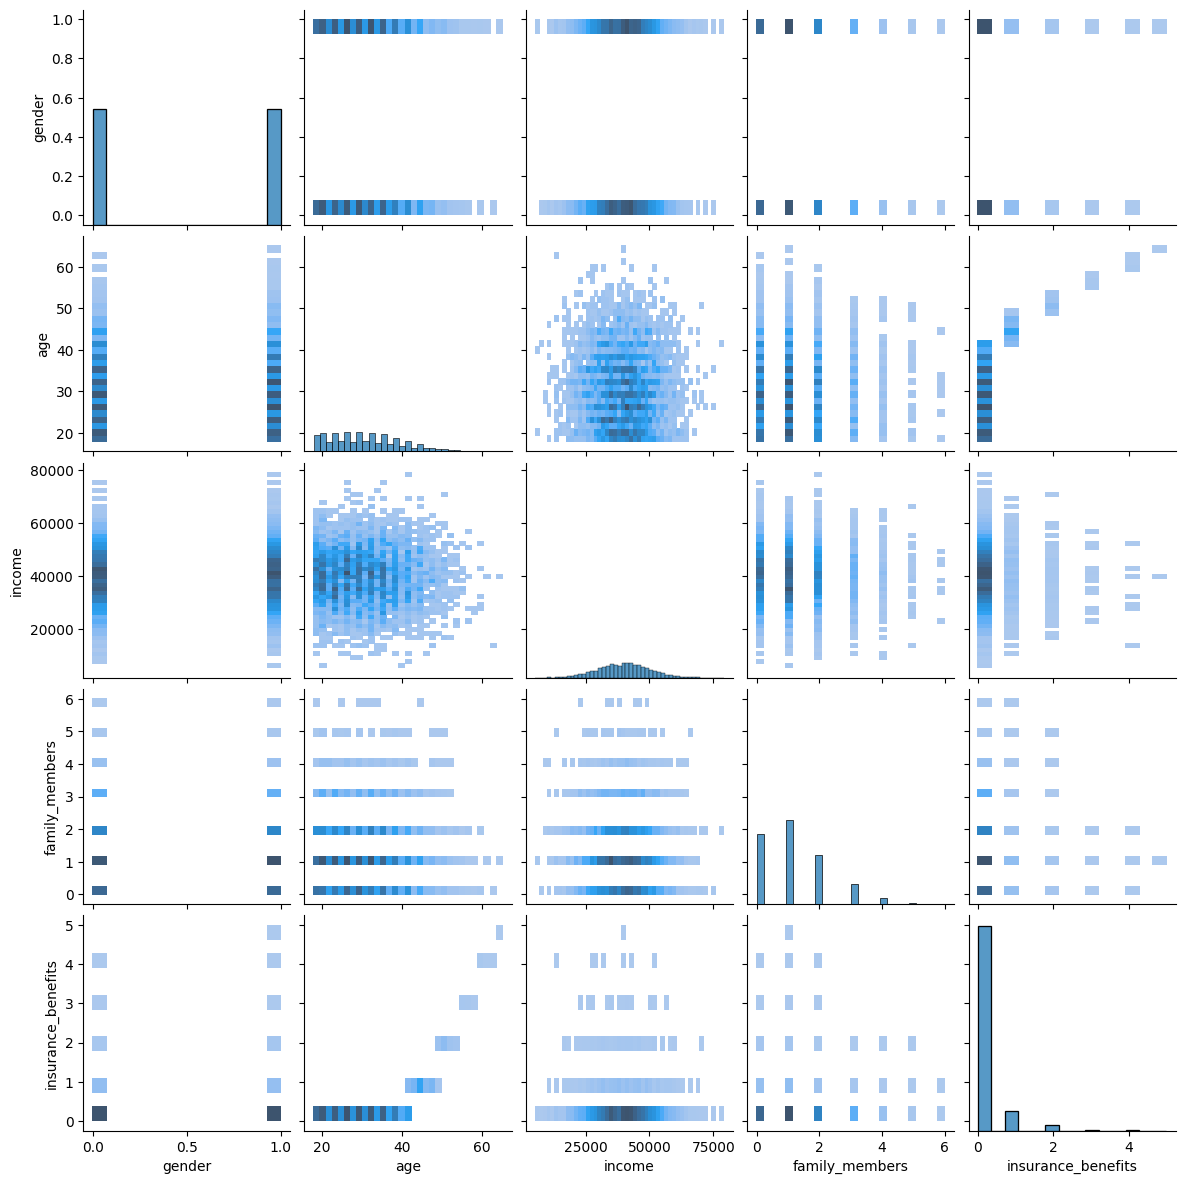

In [11]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

It is difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). 

# Task 1. Similar Customers

Develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

Write function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

Implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan


In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [13]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
    # Instantiate the NearestNeighbors object with k, metric
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    
    # Fit the model with the DataFrame excluding the target/index n
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [15]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
4593,1.0,0.338462,0.793671,0.166667,0
2773,1.0,0.369231,0.330380,0.333333,0
3160,1.0,0.323077,0.550633,0.166667,0
406,1.0,0.553846,0.522785,0.000000,0
4826,0.0,0.400000,0.515190,0.333333,0


Now, let's get similar records for a given one for every combination

In [16]:
# List of distance metrics
metrics = ['euclidean', 'manhattan']

# Define the number of nearest neighbors
k = 8

# Define the sample customer index 
n = 3

# Original data (non-scaled)
print("Finding similar records (non-scaled):")
for metric in metrics:
    similar_records = get_knn(df, n, k, metric)
    print(f"\nUsing metric: {metric}")
    print(similar_records)

# Scaled data
print("\nFinding similar records (scaled):")
for metric in metrics:
    similar_records = get_knn(df_scaled, n, k, metric)
    print(f"\nUsing metric: {metric}")
    print(similar_records)

Finding similar records (non-scaled):

Using metric: euclidean
      gender  age   income  family_members  insurance_benefits  distance
3894       0   21  41700.0               2                   0  0.000000
3          0   21  41700.0               2                   0  0.000000
2102       0   23  41700.0               0                   0  2.828427
416        0   25  41700.0               2                   0  4.000000
4872       1   26  41700.0               2                   0  5.099020
4275       0   26  41700.0               0                   0  5.385165
2289       0   27  41700.0               0                   0  6.324555
2001       0   28  41700.0               0                   0  7.280110

Using metric: manhattan
      gender  age   income  family_members  insurance_benefits  distance
3          0   21  41700.0               2                   0       0.0
3894       0   21  41700.0               2                   0       0.0
2102       0   23  41700.0          

In [17]:
# Define the number of nearest neighbors
k = 10

# Define the sample customer index 
n = 0

# Original data (non-scaled)
print("Finding similar records (non-scaled):")
for metric in metrics:
    similar_records = get_knn(df, n, k, metric)
    print(f"\nUsing metric: {metric}")
    print(similar_records)

# Scaled data
print("\nFinding similar records (scaled):")
for metric in metrics:
    similar_records = get_knn(df_scaled, n, k, metric)
    print(f"\nUsing metric: {metric}")
    print(similar_records)

Finding similar records (non-scaled):

Using metric: euclidean
      gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0  0.000000
2022       1   41  49600.0               0                   0  1.000000
1225       0   42  49600.0               0                   1  1.732051
4031       1   44  49600.0               2                   1  3.162278
3424       0   38  49600.0               0                   0  3.316625
815        1   37  49600.0               2                   0  4.123106
4661       0   45  49600.0               0                   1  4.242641
2125       0   37  49600.0               2                   0  4.242641
2349       1   46  49600.0               2                   1  5.099020
3900       1   36  49600.0               0                   0  5.099020

Using metric: manhattan
      gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0          

**Does the data being not scaled affect the kNN algorithm?** 

Unscaled data significantly affects the kNN algorithm. Features with larger numeric ranges (like income) dominate the distance calculations.  This forces features like age and gender with smaller numerical ranges to become miniscule. This kNN algorithm  relying on the feature with the largest range can bias nearest neighbor results.

Scaling data forces each feature to have equal contributions to the distance calculation. The kNN algorithm is able to find more accurate nearest neighbors. This leads to more reasonable predictions and better representation of the actual similarity between the data points.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The Manhattan distance is consistenlty less sensitive to outliers since it calculates distances as the sum of absolute differences. Regardless of scaling the distance increases incrementally for each row. 


# Task 2. Is Customer Likely to Receive Insurance Benefit?

Binary Classification Task:
With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [18]:
# calculate the target
df['insurance_benefits_received'] = (df['insurance_benefits']>0).astype(int)

In [19]:
# check for the class imbalance with value_counts()
df['insurance_benefits_received'].value_counts()


0    4436
1     564
Name: insurance_benefits_received, dtype: int64

In [20]:
X = df[['gender', 'age', 'income', 'family_members']]
y = df['insurance_benefits_received']

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled= train_test_split(X_scaled, y, test_size=0.3, random_state=42)
   
f1_scores_original = []
f1_scores_scaled = []
   
for k in range(1, 11):
    # Original data
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1_scores_original.append(f1_score(y_test, y_pred))
   
    # Scaled data
    knn.fit(X_train_scaled, y_train)
    y_pred_scaled = knn.predict(X_test_scaled)
    f1_scores_scaled.append(f1_score(y_test, y_pred_scaled))
   
print("F1 Scores for Original Data: ", f1_scores_original)
print("F1 Scores for Scaled Data: ", f1_scores_scaled)
   

F1 Scores for Original Data:  [0.6523297491039427, 0.3762376237623762, 0.3870967741935483, 0.15555555555555553, 0.1675392670157068, 0.09411764705882353, 0.11560693641618497, 0.024539877300613494, 0.03658536585365854, 0.03658536585365854]
F1 Scores for Scaled Data:  [0.9333333333333332, 0.9174917491749175, 0.9358974358974359, 0.9169435215946844, 0.9392971246006389, 0.9169435215946844, 0.9389067524115757, 0.912751677852349, 0.934640522875817, 0.9199999999999999]


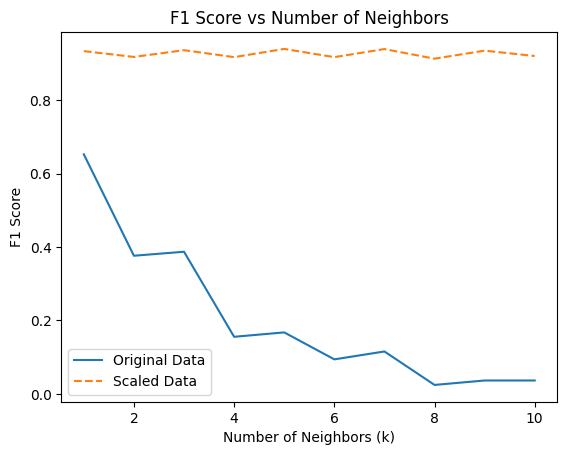

In [23]:
import matplotlib.pyplot as plt
   
plt.plot(range(1, 11), f1_scores_original, label='Original Data')
plt.plot(range(1, 11), f1_scores_scaled, label='Scaled Data', linestyle='--')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Neighbors')
plt.legend()
plt.show()
   

In [24]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [25]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [26]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



# Task 3. Regression (with Linear Regression)

Evaluate what RMSE would be for a Linear Regression model.

Check RMSE for both the original data and the scaled one; spot differences.

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [27]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y


    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones((len(X), 1)), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [28]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [29]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print('Original Linear Regression Results:')
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

Original Linear Regression Results:
[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [30]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled= train_test_split(X_scaled, y, test_size=0.3, random_state=12345)


In [31]:
print('Scaled Linear Regression Results:')
lr.fit(X_train_scaled, y_train_scaled)
print(lr.weights)

y_test_pred = lr.predict(X_test_scaled)
eval_regressor(y_test_scaled, y_test_pred)

Scaled Linear Regression Results:
[ 0.14683845  0.00821362  0.30172486 -0.00258113 -0.01275726]
RMSE: 0.34
R2: 0.66


# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Check how the features' values will look like after the transformation. Intertible property is important here so make sure that $P$ is indeed invertible.


In [32]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [33]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [34]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [35]:
P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

Checking the matrix $P$ is invertible

In [36]:
inverse=np.linalg.inv(P)
print(inverse)

[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


Matrix P is invertible. 

Recover the original data from $X'$ if $P$ is known? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [37]:
inverse/P

array([[  0.5357926 ,  -3.27616849,   0.73140808,   1.63473608],
       [-11.26616867,   0.45324236,   0.17467871,   1.506568  ],
       [ 11.11220085,   3.56275793,  -5.54313174,  -1.65845383],
       [ -0.17284016,  -0.79991338,   3.94654743,  -0.51999573]])

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [38]:

# Transform the original data
transformed = np.dot(X, P)

# Compute the inverse of P
P_inverse = np.linalg.inv(P)

# Recover the original data
recovered = np.dot(transformed, P_inverse)

# Print results for demonstration purposes
# (You can customize this to print a few customers)
print("Original Data:")
print(X)

print("\nTransformed Data:")
print(transformed)

print("\nRecovered Data:")
print(recovered)

Original Data:
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]

Transformed Data:
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]

Recovered Data:
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 ...
 [-1.92837871e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04  3

Some values may n ot be exactly the same due to numpy only functioning with double precision.  Project matrixes have values at e-13.  Rounding errors can still occur. 

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same.

If formula was simpliefied $w$ and $w_P$ would be linked as $w_P$= P^-1w.  The predicted values are the same as using w.  The obfuscation through 𝑃 does not alter the predictions. RMSE the discrepeancy between the true values and the predicted values.  The quality of linear regression measured with RMSE remains unchanged since the predicted values $y_P$ with $w_P$ identical to y with w. 

**Analytical proof**

Given that 
$$w = (X^TX)^{-1}X^Ty$$
$$w_P = [(XP)^T(XP)]^{-1}(XP)^Ty$$
1. Based on reversaity of transpose of matrix product on first half of equation: 
$$ w_P = [(XP)^TXP]^{-1} (XP)^Ty$$
2. associative property of multiplication
$$ w_P = [(P^TX^TX)P]^{-1} (XP)^Ty$$
3. multiplicative identity property
$$ w_P = P^{-1}[P^TX^TX]^{-1} (XP)^Ty$$
4. multiplicative identity property
$$ w_P = P^{-1}[X^TX]^{-1}[P^T]^{-1} (XP)^Ty$$
5. Based on reversaity of transpose of matrix product on second half of equation: 
$$ w_P = P^{-1}[X^TX]^{-1}[P^T]^{-1} (P^TX^Ty)$$
6. Identify and remove present identity matrix for P
$$ w_P = P^{-1}[X^TX]^{-1}IX^Ty$$
$$ w_P = P^{-1}[X^TX]^{-1}X^Ty$$
7. Use w since definition present
$$ w_P = P^{-1} w$$

Linear regression is y=X(features) *w (weights)
$$Y=XW$$
$$yP=XP*wp$$
insert in found formula for wp
$$yP=XPP^{-1}w$$
associative property of communication 
$$yp=X*(PP^{-1})w $$
remove identity matrix 
$$yP=Xw$$
There will not be a different result because if P is inverse we will achieve same result. 



## Test Linear Regression With Data Obfuscation

Prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. 

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

In [39]:
rng = np.random.default_rng(seed=50)
P = rng.random(size=(X.shape[1], X.shape[1]))
inverse=np.linalg.inv(P)
print(inverse)

[[ 3.52874725 -3.73691871 -1.63170675 -0.72173547]
 [-0.31181108  2.06688505  0.14025018 -0.91461612]
 [-0.93969328  0.59778077  1.49732213 -0.01247502]
 [-1.03118507  0.91623605  0.35701011  1.37411748]]


In [40]:
# Linear regression function with option to obfuscate
def linear_regression(X, y, P=None):
    if P is not None:
        X = np.dot(X, P)
        
    lr = LinearRegression()
    lr.fit(X, y)
    y_pred = lr.predict(X)
    
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    
    return lr, y_pred, rmse, r2

# Splitting original data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Original Dataset: Train the model
lr_original, y_pred_original, rmse_original, r2_original = linear_regression(X_train, y_train)

# Use the trained model to make predictions on the test set
y_pred_test_original = lr_original.predict(X_test)
rmse_test_original = mean_squared_error(y_test, y_pred_test_original, squared=False)  
r2_test_original = r2_score(y_test, y_pred_test_original)

print("Original Dataset Evaluation")
print("RMSE:", rmse_test_original)
print("R2:", r2_test_original)


# Obfuscated Dataset: Train the model with obfuscated training data
lr_obfuscated, y_pred_obfuscated, rmse_obfuscated, r2_obfuscated = linear_regression(X_train, y_train, P)

# Obfuscate the test data using the same invertible matrix
X_test_obfuscated = np.dot(X_test, P)

# Use the trained model to make predictions on the obfuscated test set
y_pred_test_obfuscated = lr_obfuscated.predict(X_test_obfuscated)
rmse_test_obfuscated = mean_squared_error(y_test, y_pred_test_obfuscated, squared=False) 
r2_test_obfuscated = r2_score(y_test, y_pred_test_original)
print('******************************************')
print("Obfusciated Data Evaluation")
print("RMSE:", rmse_test_obfuscated)
print("R2:", r2_test_obfuscated)

Original Dataset Evaluation
RMSE: 0.3637189976119266
R2: 0.4226999694460717
******************************************
Obfusciated Data Evaluation
RMSE: 0.3637189976118563
R2: 0.4226999694460717


# Conclusions

RMSE and ( R^2 ): The RMSE and ( R^2 ) values for both the original and obfuscated datasets are very similar. They only differ by a tenth decimal point.  Providing an indication that the obfuscation process did not significantly impact the performance of the Linear Regression. 


The transformation by an invertible matrix does not degrade the quality of the linear model.In using a random matrix for obfuscation the linear regression maintained the ability to make accurate predictions.

Sensitive data can be obfuscated to protect it without sacrificing the accuracy of predictive models. Sure Tomorrow insurance company is enable to share data more securely.
